In [12]:
import os
import random
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import cv2

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torchvision.io import read_image

# Scikit-learn imports
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split

# Qiskit imports
import qiskit
from qiskit import transpile
from qiskit import QuantumCircuit as QiskitQuantumCircuit
from qiskit_aer import Aer

# Additional libraries
import torchxrayvision as xrv

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {torch.cuda.get_device_name(device)}")
print(f"Qiskit: {qiskit.__version__}")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
Qiskit: 1.2.4


In [14]:
class MammoDataset(Dataset):
    def __init__(self, root_dir, train=True, data_augmentation=False):
        self.image_paths = []
        self.labels = []
        
        # Define the base transform
        base_transform = [transforms.Resize((250, 250)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.3577, 0.3577, 0.3577], std=[0.2662, 0.2662, 0.2662])]
        
        # Add data augmentation if specified
        if train and data_augmentation:
            augmentation_transform = [transforms.RandomVerticalFlip(),
                                      transforms.GaussianBlur(kernel_size=(3, 3))]
            self.transform = transforms.Compose(augmentation_transform + base_transform)
        else:
            self.transform = transforms.Compose(base_transform)
        
        # Collect image paths and labels
        for label in ['0', '1']:
            folder_path = os.path.join(root_dir, label)
            self.image_paths.extend([os.path.join(folder_path, img_name) for img_name in os.listdir(folder_path)])
            self.labels.extend([int(label)] * len(os.listdir(folder_path)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [15]:
class Resnet(torch.nn.Module):
    def __init__(self, out_features = 2):
        super(Resnet, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, out_features)
    def forward(self, x):
        return self.resnet(x)

In [16]:
class QuantumCircuit:    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta_0 = qiskit.circuit.Parameter('theta0')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta_0, all_qubits)
        #self._circuit.rx(self.theta, all_qubits)
        
        self._circuit.measure_all()
        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        param_values = {
            self.theta_0: thetas[0],
        }
        
        bound_circuit = self._circuit.assign_parameters(param_values)
        transpiled_circuit = transpile(bound_circuit, self.backend)
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        
        result = job.result().get_counts()
        
        expectations = []

        if isinstance(result, list):
            for i in result:
                counts = np.array(list(i.values()))
                states = np.array(list(i.keys())).astype(float)
                
                # Compute probabilities for each state
                probabilities = counts / self.shots
                
                # Get state expectation
                expectation = np.sum(states * probabilities)
                expectations.append(expectation)
        else:
            # If result is not a list, treat it as a single result
            counts = np.array(list(result.values()))
            states = np.array(list(result.keys())).astype(float)
            
            probabilities = counts / self.shots
            expectation = np.sum(states * probabilities)
            expectations.append(expectation)
            return np.array(expectations)

In [17]:
class HybridFunction(torch.autograd.Function):
    """ Hybrid quantum-classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        # Run the quantum circuit and get the expectation value
        expectation_z = ctx.quantum_circuit.run(input.tolist()[0])
        
        # Ensure the result tensor is created on the same device as the input
        result = torch.tensor([expectation_z], device=input.device)
        
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = input.tolist()[0]  # Get the input values as a list
        
        # Convert input_list to a tensor for arithmetic operations
        input_tensor = torch.tensor(input_list, device=input.device)
        
        shift_value = ctx.shift * torch.ones_like(input_tensor)  # Create a tensor for shift
        
        shift_right = input_tensor + shift_value
        shift_left = input_tensor - shift_value
        
        gradients = []
        for i in range(len(input_tensor)):
            expectation_right = ctx.quantum_circuit.run([shift_right[i].item()])
            expectation_left  = ctx.quantum_circuit.run([shift_left[i].item()])
            
            # Compute the gradient as the difference
            gradient = expectation_right - expectation_left
            gradients.append(gradient)

        # Convert the list of gradients to a tensor
        gradients = torch.tensor(gradients, device=input.device).float()  # Ensure gradients are on the same device
        return gradients * grad_output.float(), None, None


class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, n_qubits, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        batch_results = []
        for i in range(input.shape[0]):
            result = HybridFunction.apply(input[i].unsqueeze(0), self.quantum_circuit, self.shift)
            batch_results.append(result)
        return torch.cat(batch_results)

In [18]:
class qcNet(nn.Module):
    def __init__(self):
        super(qcNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(6, 15, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop1 = nn.Dropout2d(p=0.2)
        self.drop2 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(55815, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        sim = Aer.get_backend('aer_simulator_statevector')
        self.hybrid = Hybrid(self.fc3.out_features, sim, 1000, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x)
        x = torch.cat((x, 1 - x), -1)
        return x

In [19]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Load pre-trained ResNet50 model
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         # Modify the fully connected layer to match the required output features
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 84)
        
#         self.drop1 = nn.Dropout2d(p=0.2)
#         self.drop2 = nn.Dropout2d(p=0.5)
#         self.fc1 = nn.Linear(84, 1)
#         sim = AerSimulator()
#         self.hybrid = Hybrid(self.fc1.out_features, sim, 1000, np.pi / 2)

#     def forward(self, x):
#         x = self.resnet(x)
#         x = self.drop1(x)
#         x = F.relu(self.fc1(x))
#         x = self.hybrid(x)
#         x = torch.cat((x, 1 - x), -1)
#         return x

In [20]:
train_dir = '/mnt/c/Users/Win10/Desktop/researchData/data/png/train'
test_dir = '/mnt/c/Users/Win10/Desktop/researchData/data/png/test'

# Instancia os datasets

train_dataset = MammoDataset(root_dir=train_dir, data_augmentation=True)
test_dataset = MammoDataset(root_dir=test_dir, train=False)

# Cria os DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
model = qcNet().to(device)
loss_func = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
loss_list = []
thetas = []

In [22]:
model.train()
for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (image, label) in enumerate(train_loader):
        label = label.unsqueeze(1)
        
        # Converta os tensores para o tipo correto
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()  # Zere os gradientes

        # Passe as imagens pelo modelo
        prediction = model(image.to(device))

        prediction = prediction.to(device)

        #Get prediction label from the index with the maximum score
        #prediction_label = torch.argmax(prediction, dim=1)
        print(prediction)

        #prediction_label = prediction_label.unsqueeze(1)
        # Calcule a perda
        
        loss = loss_func(prediction, label.squeeze().long())

        # Propagação para trás e atualização dos pesos
        loss.backward()
        optimizer.step()

        # Armazene as informações
        total_loss.append(loss.item())
        print(f"  Batch {batch_idx + 1} concluído com loss: {loss.item():.4f}")
        
    avg_loss = np.mean(total_loss)
    loss_list.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

    model_save_path = f"model_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)

tensor([[0.5810, 0.4190],
        [0.5700, 0.4300],
        [0.5630, 0.4370],
        [0.5820, 0.4180],
        [0.5490, 0.4510],
        [0.5270, 0.4730],
        [0.5860, 0.4140],
        [0.5520, 0.4480],
        [0.5570, 0.4430],
        [0.5180, 0.4820],
        [0.5350, 0.4650],
        [0.5540, 0.4460],
        [0.5770, 0.4230],
        [0.6070, 0.3930],
        [0.5640, 0.4360],
        [0.5120, 0.4880],
        [0.5580, 0.4420],
        [0.5560, 0.4440],
        [0.5700, 0.4300],
        [0.5440, 0.4560],
        [0.6050, 0.3950],
        [0.5900, 0.4100],
        [0.5410, 0.4590],
        [0.5920, 0.4080],
        [0.5510, 0.4490],
        [0.5340, 0.4660],
        [0.5500, 0.4500],
        [0.5540, 0.4460],
        [0.5530, 0.4470],
        [0.5590, 0.4410],
        [0.5180, 0.4820],
        [0.5470, 0.4530],
        [0.5610, 0.4390],
        [0.5830, 0.4170],
        [0.6020, 0.3980],
        [0.5710, 0.4290],
        [0.5430, 0.4570],
        [0.5450, 0.4550],
        [0.5

In [23]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch_idx, (image, label) in enumerate(test_loader):
        label = label.unsqueeze(1)
        
        # Converta os tensores para o tipo correto
        image = image.to(device)
        label = label.to(device)
        # image, label = image.type(dtype=torch.cuda.FloatTensor), label.type(dtype=torch.cuda.LongTensor)
        try:
            prediction = model(image)
            predicted_class = prediction.argmax(dim=1)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_class.cpu().numpy())
        except:
            continue

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calcular acurácia
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Acurácia: {accuracy:.4f}")

Precision: 0.3077
Recall: 0.4800
F1 Score: 0.3750
Acurácia: 0.5122


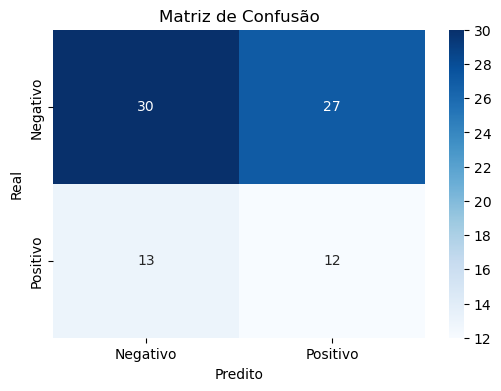

In [24]:
# Gerar matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()